Box(children=(VBox(children=(HTML(value="<h2 style='color:white; text-align:center;'>Credit Card Fraud Detecti…

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

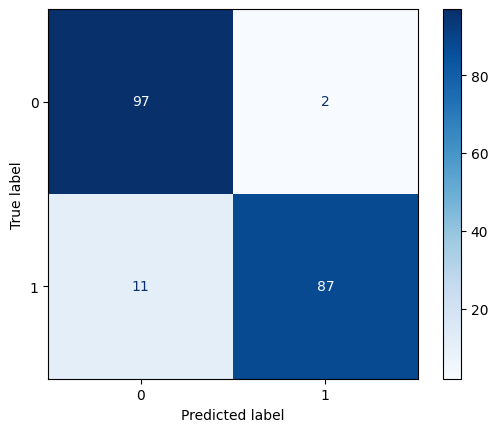

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import ipywidgets as widgets
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

# Load dataset
"df = pd.read_csv(r\"creditcard.csv")\n",

legit = df[df.Class == 0]
fraud = df[df.Class == 1]

# Under-sampling
legit_sample = legit.sample(n=492)
new_dataset = pd.concat([legit_sample, fraud], axis=0)

X = new_dataset.drop(columns='Class', axis=1)
Y = new_dataset['Class']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_scaled, Y_train)

# Convert the scaled data back to DataFrame to retain feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)
model.fit(X_train_scaled_df, Y_train)

X_train_prediction = model.predict(X_train_scaled_df)
training_data_accuracy = accuracy_score(Y_train, X_train_prediction)
X_test_prediction = model.predict(X_test_scaled_df)
test_data_accuracy = accuracy_score(Y_test, X_test_prediction)

# Suppress specific sklearn warnings and replace them with custom messages
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# Function to handle predictions
def predict_transaction(features):
    try:
        # Convert features to numpy array
        features = np.array([float(i) for i in features.split(',')]).reshape(1, -1)
        
        # Scale the features
        features_scaled = scaler.transform(features)
        
        # Predict the class
        prediction = model.predict(features_scaled)
        prediction_proba = model.predict_proba(features_scaled)
        
        result = 'Fraudulent' if prediction[0] == 1 else 'Legitimate'
        confidence = prediction_proba[0][prediction[0]]
        
        return f"Prediction: {result}<br>Confidence: {confidence:.2f}"
    except Exception as e:
        return f"Error: {e}"

# Generate the classification report as a dictionary
report_dict = classification_report(Y_test, X_test_prediction, output_dict=True)

# Extract and format the accuracy value to 11 decimal places
accuracy = report_dict['accuracy']
formatted_accuracy = f"{accuracy:.11f}"

# Function to convert classification report dictionary to an HTML table with colored cells
def classification_report_to_html(report):
    def get_color(value):
        """Get color based on value for heatmap effect."""
        if value > 100:
            color = f"rgba(0, 0, 255, {value})"  # Blue
        elif value >= 0.75:
            color = f"rgba(255, 255, 0, {value})"  # Yellow
        elif value >= 0.5:
            color = f"rgba(0, 255, 0, {value})"  # Green
        else:
            color = f"rgba(255, 0, 0, {value})"  # Red
        return color

    html = "<table style='width:100%; color:black; background-color:white; border-collapse: collapse;'>"
    html += "<thead><tr style='border:1px solid black;'>"
    html += "<th style='border:1px #333; background-color:#333;'></th>"  # Empty header cell with black background
    for col in report['0'].keys():
        html += f"<th style='border:1px solid black; background-color:white;'>{col}</th>"
    html += "</tr></thead><tbody>"
    for label, metrics in report.items():
        html += f"<tr style='border:1px solid black;'><td style='border:1px solid black; background-color:white;'>{label}</td>"
        if isinstance(metrics, dict):
            for key, value in metrics.items():
                color = get_color(value)
                html += f"<td style='border:1px solid black; background-color:{color};'>{value:.2f}</td>"
        else:
            html += f"<td style='border:1px solid black;' colspan='{len(report['0'])}'>{metrics:.2f}</td>"
        html += "</tr>"
    html += "</tbody></table>"
    return html

# Create the text box widget with increased width and height
text_box = widgets.Textarea(
    value='',
    placeholder='Enter features here... e.g., 0,-1.359807134,-0.072781173,2.536346738,1.378155224,-0.33832077,0.462387778,0.239598554,0.098697901,0.36378697,0.090794172,-0.551599533,-0.617800856,-0.991389847,-0.311169354,1.468176972,-0.470400525,0.207971242,0.02579058,0.40399296,0.251412098,-0.018306778,0.277837576,-0.11047391,0.066928075,0.128539358,-0.189114844,0.133558377,-0.021053053,149.62',
    description='Features:',
    disabled=False,
    layout=widgets.Layout(width='80%', height='80px', background_color='#333', color='white')
)

# Create the button widget with vertical alignment
clear_button = widgets.Button(
    description='Clear Data',
    disabled=False,
    button_style='danger',
    tooltip='Click to clear',
    icon='trash',
    layout=widgets.Layout(margin='20px 30px 30px 60px', background_color='#333', color='white')
)

submit_button = widgets.Button(
    description='Submit',
    disabled=False,
    button_style='success',
    tooltip='Click to submit',
    icon='check',
    layout=widgets.Layout(margin='20px 30px 30px 100px', background_color='#333', color='white')
)

output = widgets.Output()

def on_clear_button_click(b):
    text_box.value = ''

def on_submit_button_click(b):
    with output:
        output.clear_output()
        result = predict_transaction(text_box.value)
        # Display the result with white-colored text
        display(HTML(f"<span style='color:white;'>{result}</span>"))

class_report_html = classification_report_to_html(report_dict)

clear_button.on_click(on_clear_button_click)
submit_button.on_click(on_submit_button_click)

# Create the header using HTML widget
header1 = widgets.HTML("<h2 style='color:white; text-align:center;'>Credit Card Fraud Detection Using Logistic Regression Model</h2>")
header2 = widgets.HTML(f"<h3 style='color:white; text-align:center;'><i>Model Accuracy Score</i>: {formatted_accuracy}</h3>")
header3 = widgets.HTML("<h2 style='color:white; text-align:center;'>Enter features to check if the transaction is legitimate or fraudulent</h2>")
header4 = widgets.HTML(f"<h3 style='color:white; text-align:center;'>Classification Report</h3>{class_report_html}")
header5 = widgets.HTML(f"<h3 style='color:white; text-align:center; margin-bottom: -8px;'>Class Distribution</h3>")
header6 = widgets.HTML(f"<h3 style='color:white; text-align:center;'>Visualising the count of each class using bar plot</h3>")
header7 = widgets.HTML(f"<h3 style='color:white; text-align:center; margin-bottom: -8px;'>Amount Distribution</h3>")
header8 = widgets.HTML(f"<h3 style='color:white; text-align:center;'>Visualising the transaction amounts using histogram and box Plot</h3>")
header9 = widgets.HTML(f"<h3 style='color:white; text-align:center; margin-bottom: -8px;'>Time Distribution</h3>")
header10 = widgets.HTML(f"<h3 style='color:white; text-align:center;'>Visualising the time of transactions using histogram and box plot</h3>")
header11 = widgets.HTML(f"<h3 style='color:white; text-align:center; margin-bottom: -8px;'>Correlation Matrix</h3>")
header12 = widgets.HTML(f"<h3 style='color:white; text-align:center;'>Visualising the correlation matrix using heatmap</h3>")
header13 = widgets.HTML(f"<h3 style='color:white; text-align:center; margin-bottom: -8px;'>Pairplot</h3>")
header14 = widgets.HTML(f"<h3 style='color:white; text-align:center;'>Visualising the relationships between pairs of features using pairplot</h3>")
header15 = widgets.HTML(f"<h3 style='color:white; text-align:center; margin-bottom: -8px'><i>before sampling</i></h3>")
header16 = widgets.HTML(f"<h3 style='color:white; text-align:center; margin-bottom: -8px'><i>after sampling</i></h3>")
header18 = widgets.HTML(f"<h3 style='color:white; text-align:center; margin-bottom: -8px;'>ROC Curve</h3>")
header19 = widgets.HTML(f"<h3 style='color:white; text-align:center;'>Visualising the true positive rate against the false positive rate.</h3>")
header20 = widgets.HTML(f"<h3 style='color:white; text-align:center; margin-bottom: -8px;'>Precision-Recall Curve</h3>")
header21 = widgets.HTML(f"<h3 style='color:white; text-align:center;'>Visualising precision vs. recall for different thresholds.</h3>")
header22 = widgets.HTML(f"<h3 style='color:white; text-align:center; margin-bottom: -8px;'>Confusion Matrix</h3>")
header23 = widgets.HTML(f"<h3 style='color:white; text-align:center;'>Visualising the performance of the classification model by showing the true positive, true negative, false positive, and false negative counts.</h3>")

# Center the text box and buttons
text_box_box = widgets.Box([text_box], layout=widgets.Layout(display='flex', justify_content='center'))
button_box = widgets.Box([clear_button, submit_button], layout=widgets.Layout(display='flex', justify_content='center'))

# Generate and save the plot as an image
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution before sampling')
plot_file_before = 'class_distribution_before.png'
plt.savefig(plot_file_before)
plt.close()

plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=new_dataset)
plt.title('Class Distribution after sampling')
plot_file_after = 'class_distribution_after.png'
plt.savefig(plot_file_after)
plt.close()

# Display the saved images using Image widgets
image_widget_before = widgets.Image(
    value=open(plot_file_before, 'rb').read(),
    format='png',
    width=600,
    height=400
)

image_widget_after = widgets.Image(
    value=open(plot_file_after, 'rb').read(),
    format='png',
    width=600,
    height=400
)

# Generate and save the amount distribution plots - Histogram 
plt.figure(figsize=(10, 6))
df['Amount'].hist(bins=50)
plt.title('Transaction Amount Distribution before sampling')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plot_file_amount_before_histogram = 'amount_distribution_before_Histogram.png'
plt.savefig(plot_file_amount_before_histogram)
plt.close()

plt.figure(figsize=(10, 6))
new_dataset['Amount'].hist(bins=50)
plt.title('Transaction Amount Distribution after sampling')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plot_file_amount_after_histogram = 'amount_distribution_after_Histogram.png'
plt.savefig(plot_file_amount_after_histogram)
plt.close()

# Generate and save the amount distribution plots - Box Plot 
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Amount Distribution by Class before Sampling')
plot_file_amount_before_BoxPlot = 'amount_distribution_after_BoxPlot.png'
plt.savefig(plot_file_amount_before_BoxPlot)
plt.close()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Amount', data=new_dataset)
plt.title('Amount Distribution by Class after Sampling')
plot_file_amount_after_BoxPlot = 'amount_distribution_after_BoxPlot.png'
plt.savefig(plot_file_amount_after_BoxPlot)
plt.close()

# Display the saved images using Image widgets
image_widget_amount_histogram_before = widgets.Image(
    value=open(plot_file_amount_before_histogram, 'rb').read(),
    format='png',
    width=600,
    height=400
)

image_widget_amount_histogram_after = widgets.Image(
    value=open(plot_file_amount_after_histogram, 'rb').read(),
    format='png',
    width=600,
    height=400
)

image_widget_amount_BoxPlot_before = widgets.Image(
    value=open(plot_file_amount_before_BoxPlot, 'rb').read(),
    format='png',
    width=600,
    height=400
)

image_widget_amount_BoxPlot_after = widgets.Image(
    value=open(plot_file_amount_after_BoxPlot, 'rb').read(),
    format='png',
    width=600,
    height=400
)

# Generate and save the time distribution plots - histogram
plt.figure(figsize=(10, 6))
df['Time'].hist(bins=50)
plt.title('Transaction Time Distribution before Sampling')
plt.xlabel('Time')
plt.ylabel('Frequency')
plot_file_time_before_histogram = 'time_distribution_before_histogram.png'
plt.savefig(plot_file_time_before_histogram)
plt.close()

plt.figure(figsize=(10, 6))
new_dataset['Time'].hist(bins=50)
plt.title('Transaction Time Distribution after Sampling')
plt.xlabel('Time')
plt.ylabel('Frequency')
plot_file_time_after_histogram = 'time_distribution_after_histogram.png'
plt.savefig(plot_file_time_after_histogram)
plt.close()

# Generate and save the time distribution plots - box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Time', data=df)
plt.title('Time Distribution by Class before Sampling')
plot_file_time_before_BoxPlot = 'time_distribution_before_BoxPlot.png'
plt.savefig(plot_file_time_before_BoxPlot)
plt.close()

plt.figure(figsize=(10, 6))
sns.boxplot(x='Class', y='Time', data=new_dataset)
plt.title('Time Distribution by Class after Sampling')
plot_file_time_after_BoxPlot = 'time_distribution_after_BoxPlot.png'
plt.savefig(plot_file_time_after_BoxPlot)
plt.close()

# Display the saved images using Image widgets
image_widget_time_histogram_before = widgets.Image(
    value=open(plot_file_time_before_histogram, 'rb').read(),
    format='png',
    width=600,
    height=400
)

image_widget_time_histogram_after = widgets.Image(
    value=open(plot_file_time_after_histogram, 'rb').read(),
    format='png',
    width=600,
    height=400
)

image_widget_time_BoxPlot_before = widgets.Image(
    value=open(plot_file_time_before_BoxPlot, 'rb').read(),
    format='png',
    width=600,
    height=400
)

image_widget_time_BoxPlot_after = widgets.Image(
    value=open(plot_file_time_after_BoxPlot, 'rb').read(),
    format='png',
    width=600,
    height=400
)

# Generate and save the correlation matrix plots
plt.figure(figsize=(10, 6))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix before Sampling')
plot_file_correlation_matrix_before = 'correlation_matrix_before.png'
plt.savefig(plot_file_correlation_matrix_before)
plt.close()

plt.figure(figsize=(10, 6))
corr_matrix = new_dataset.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix after Sampling')
plot_file_correlation_matrix_after = 'correlation_matrix_after.png'
plt.savefig(plot_file_correlation_matrix_after)
plt.close()

# Display the saved images using Image widgets
image_widget_correlation_matrix_before = widgets.Image(
    value=open(plot_file_correlation_matrix_before, 'rb').read(),
    format='png',
    width=1200,
    height=400
)

image_widget_correlation_matrix_after = widgets.Image(
    value=open(plot_file_correlation_matrix_after, 'rb').read(),
    format='png',
    width=1200,
    height=400
)

# Generate and save the Pairplot
plt.figure(figsize=(10, 6))
sample_df= df.sample(n=492)  # Sample a subset to make the plot more readable
sns.pairplot(sample_df, hue='Class', vars=['V1', 'V2', 'V27', 'V28', 'Amount'])
plot_file_pairplot_before = 'pairplot_before.png'
plt.savefig(plot_file_pairplot_before)
plt.close()

plt.figure(figsize=(10, 6))
sample_new_dataset= new_dataset.sample(n=492)  # Sample a subset to make the plot more readable
sns.pairplot(sample_new_dataset, hue='Class', vars=['V1', 'V2', 'V27', 'V28', 'Amount'])
plot_file_pairplot_after = 'pairplot_after.png'
plt.savefig(plot_file_pairplot_after)
plt.close()

# Display the saved images using Image widgets
image_widget_pairplot_before = widgets.Image(
    value=open(plot_file_pairplot_before, 'rb').read(),
    format='png',
    width=1200,
    height=400
)

image_widget_pairplot_after = widgets.Image(
    value=open(plot_file_pairplot_after, 'rb').read(),
    format='png',
    width=1200,
    height=400
)

# Generate and save the ROC Curve
Y_pred_proba = model.predict_proba(X_test_scaled_df)[:,1]
fpr, tpr, _ = roc_curve(Y_test, Y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plot_file_ROC_Curve = 'ROC_Curve.png'
plt.savefig(plot_file_ROC_Curve)
plt.close()

# Display the saved images using Image widgets
image_widget_ROC_Curve = widgets.Image(
    value=open(plot_file_ROC_Curve, 'rb').read(),
    format='png',
    width=1200,
    height=400
)

# Generate and save the Precision-Recall Curve
precision, recall, _ = precision_recall_curve(Y_test, Y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plot_file_precision_recall_curve = 'precision_recall_curve.png'
plt.savefig(plot_file_precision_recall_curve)
plt.close()

# Display the saved images using Image widgets
image_widget_precision_recall_curve = widgets.Image(
    value=open(plot_file_precision_recall_curve, 'rb').read(),
    format='png',
    width=1200,
    height=400
)

# Generate and save the Confusion Matrix
cm = confusion_matrix(Y_test, X_test_prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', ax=plt.gca())
plt.title('Confusion Matrix')
plot_file_confusion_matrix = 'confusion_matrix.png'
plt.savefig(plot_file_confusion_matrix)
plt.close()

# Display the saved images using Image widgets
image_widget_confusion_matrix = widgets.Image(
    value=open(plot_file_confusion_matrix, 'rb').read(),
    format='png',
    width=1200,
    height=400
)

# Create a container box with centered content
container = widgets.Box(
    [widgets.VBox([header1, header2, header3, text_box_box, button_box, output, header4, header5, header6, widgets.HBox([image_widget_before, image_widget_after]), header7, header8, widgets.HBox([image_widget_amount_histogram_before, image_widget_amount_histogram_after]), widgets.HBox([image_widget_amount_BoxPlot_before, image_widget_amount_BoxPlot_after]), header9, header10, widgets.HBox([image_widget_time_histogram_before, image_widget_time_histogram_after]), widgets.HBox([image_widget_time_BoxPlot_before, image_widget_time_BoxPlot_after]), header11, header12, widgets.HBox([image_widget_correlation_matrix_before]), widgets.HBox([image_widget_correlation_matrix_after]), header13, header14, header15, widgets.HBox([image_widget_pairplot_before]), header16, widgets.HBox([image_widget_pairplot_after]), header18, header19, widgets.HBox([image_widget_ROC_Curve]), header20, header21, widgets.HBox([image_widget_precision_recall_curve]), header22, header23, widgets.HBox([image_widget_confusion_matrix])])],
    layout=widgets.Layout(
        display='flex',
        align_items='center',
        justify_content='center',
        width='100%',
        flex_direction='column'
    )
)

# Apply custom CSS styling for dark theme
custom_css = """
<style>
    .widget-label {
        color: white !important;
    }
    .widget-html-content {
        background-color: #333 !important;
        color: white !important;
    }
    .widget-output {
        background-color: #333 !important;
        color: white !important;
    }
    .widget-box {
        background-color: #333 !important;
    }
    table {
        width: 100%;
        border-collapse: collapse;
        color: white;
    }
    th, td {
        border: 1px solid white;
        padding: 8px;
        text-align: left;
    }
    th {
        background-color: #444;
    }
</style>
"""

display(HTML(custom_css))
display(container)
